In [1]:
from tensorflow import keras
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image as KImage
from sklearn.metrics import classification_report
import numpy as np
from imutils import paths
from libs.preprocessing import ImageToArrayPreprocessor
from libs.preprocessing import SimplePreprocessor
from libs.datasets import SimpleDatasetLoader
from sklearn.preprocessing import LabelBinarizer
from libs.utils.myplot import plot_confusion_matrix

2023-02-11 20:17:23.530180: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-11 20:17:24.174894: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/viv/miniconda3/lib/
2023-02-11 20:17:24.174932: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/viv/miniconda3/lib/
2023-02-11 20:17:24.174937: W tensorflow/compiler/tf2tensorrt/utils/py_utils

In [2]:
saved_model_path = 'model/face_mask_detection.h5'
IMG_HEIGHT = IMG_WIDTH = 96

In [3]:
# Look into the data directory
images_dir = './face-mask-12k-images-dataset/Face Mask Dataset'
test_dir = f'{images_dir}/Test'
test_img_paths = list(paths.list_images(test_dir))

In [4]:
loaded_cnn_model = keras.models.load_model(saved_model_path)

2023-02-11 20:17:25.534455: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 20:17:25.552054: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 20:17:25.552253: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-11 20:17:25.552596: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

In [5]:
# initialize the image preprocessor
sp = SimplePreprocessor(IMG_WIDTH, IMG_HEIGHT)
iap = ImageToArrayPreprocessor()
sdl = SimpleDatasetLoader(preprocessor=[sp, iap])

In [6]:
X_test, Y_test = sdl.load(test_img_paths, verbose=500)
X_test /= 255.0


[INFO] processed 500/992


In [7]:
from sklearn.utils import shuffle

X_test, Y_test = shuffle(X_test, Y_test, random_state=42)

In [8]:
Y_test[:5]

array(['WithoutMask', 'WithoutMask', 'WithoutMask', 'WithoutMask',
       'WithoutMask'], dtype='<U11')

In [9]:
lb = LabelBinarizer()
Y_test = lb.fit_transform(Y_test)

In [10]:
class_names_list = lb.classes_
class_names_list

array(['WithMask', 'WithoutMask'], dtype='<U11')

In [11]:
preds = loaded_cnn_model.predict(X_test)
preds[preds >= 0.5] = 1 
preds[preds < 0.5] = 0
print(classification_report(Y_test,
                            preds,
                            target_names=class_names_list)
      )

2023-02-11 20:17:27.777347: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8600


31/31 [==============================] - 1s 2ms/step
              precision    recall  f1-score   support

    WithMask       0.98      0.98      0.98       483
 WithoutMask       0.98      0.98      0.98       509

    accuracy                           0.98       992
   macro avg       0.98      0.98      0.98       992
weighted avg       0.98      0.98      0.98       992



2023-02-11 20:17:28.191813: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


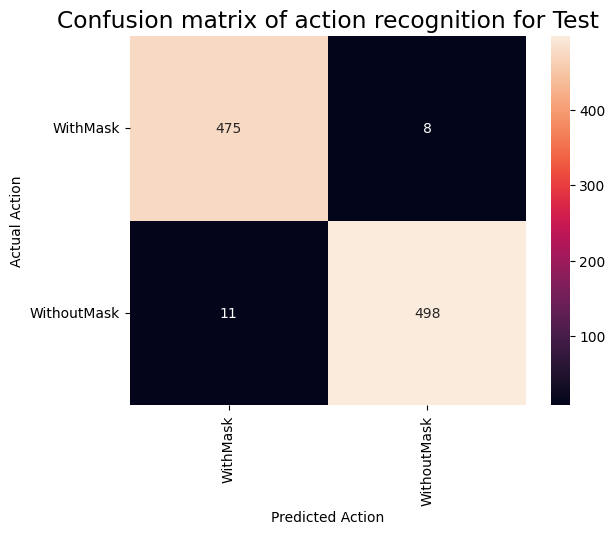

In [12]:
plot_confusion_matrix(Y_test, preds, class_names_list, 'Test')

1/1 [==============================] - 0s 85ms/step


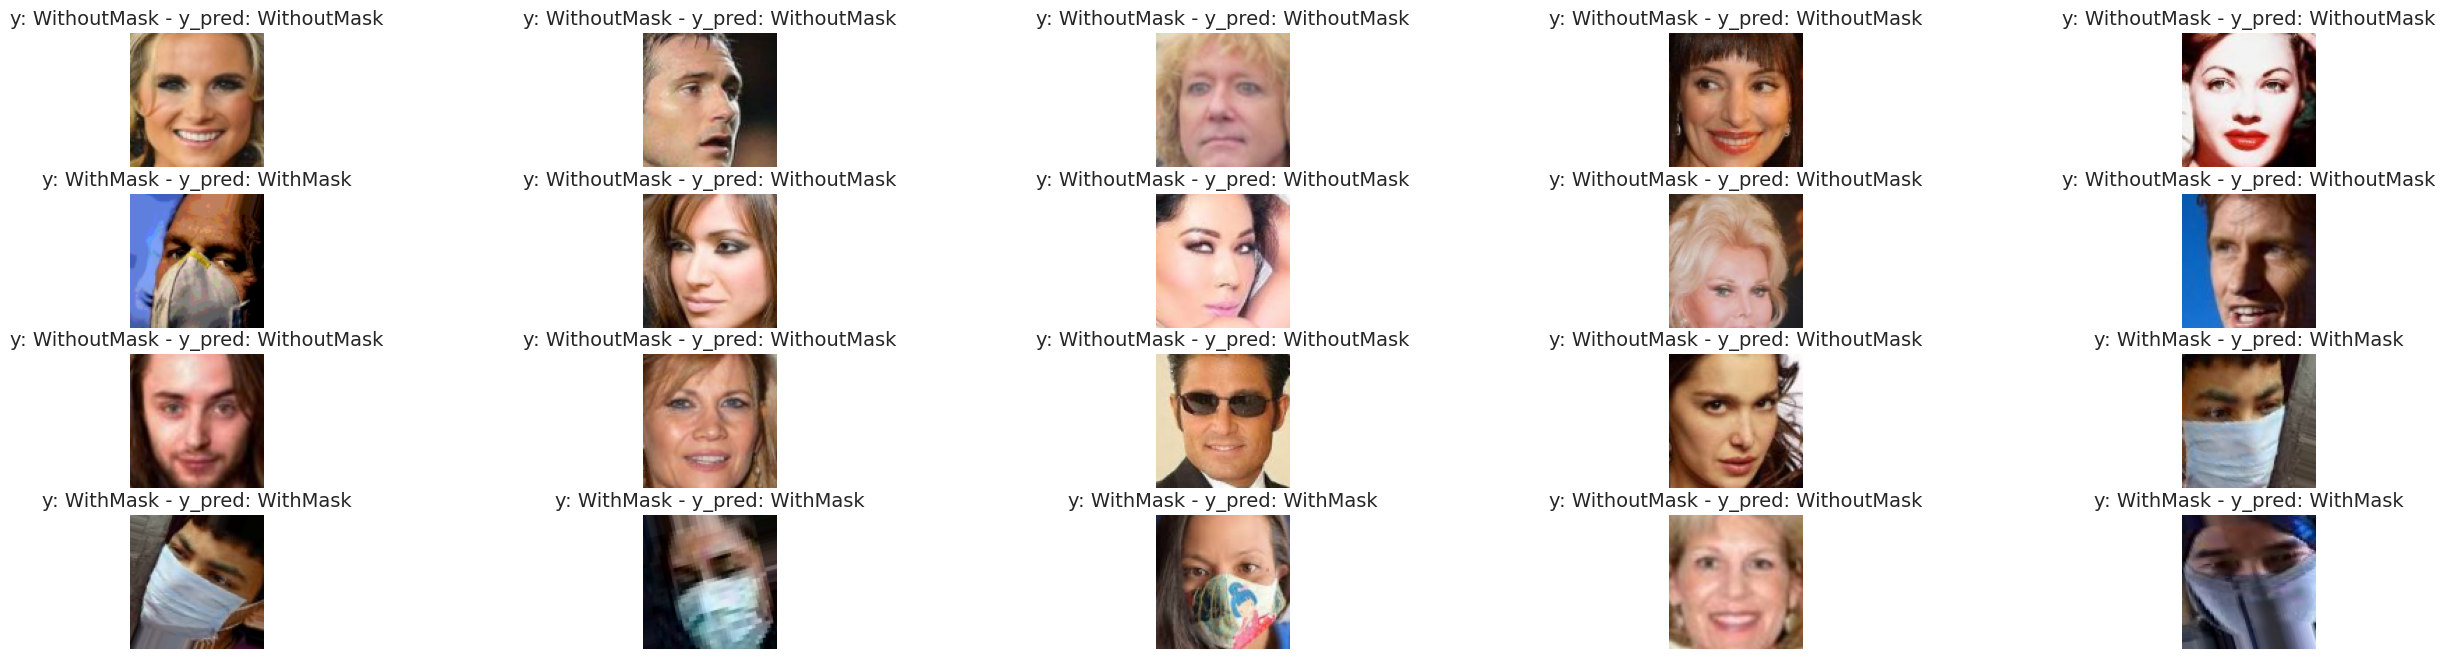

In [13]:
# True Label & Predict of a particular Batch
image, label = X_test, Y_test  #test_set.next()
num_imgs = 20
lab_names = class_names_list
images = image[0:num_imgs]
labels = label[0:num_imgs]
predict = np.round(loaded_cnn_model.predict(images))
image_rows = 4
image_col = int(num_imgs / image_rows)

_, axs = plt.subplots(image_rows, image_col, figsize=(32, 8))
axs = axs.flatten()

for i in range(num_imgs):
    img = images[i, :, :, :]
    lab = labels[i, :]
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i].imshow(image)
    pred = int(predict[i])

    axs[i].axis('off')

    axs[i].set_title(label=f'y: {lab_names[lab][0]} - y_pred: {class_names_list[pred]}', fontsize=14)

plt.show()

In [14]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    resize = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    # rgb_img = cv2.cvtColor(resize, cv2.COLOR_BGR2RGB)
    # plt.imshow(rgb_img)
    # plt.show()
    return np.expand_dims(resize / 255, 0)

1/1 [==============================] - 0s 10ms/step


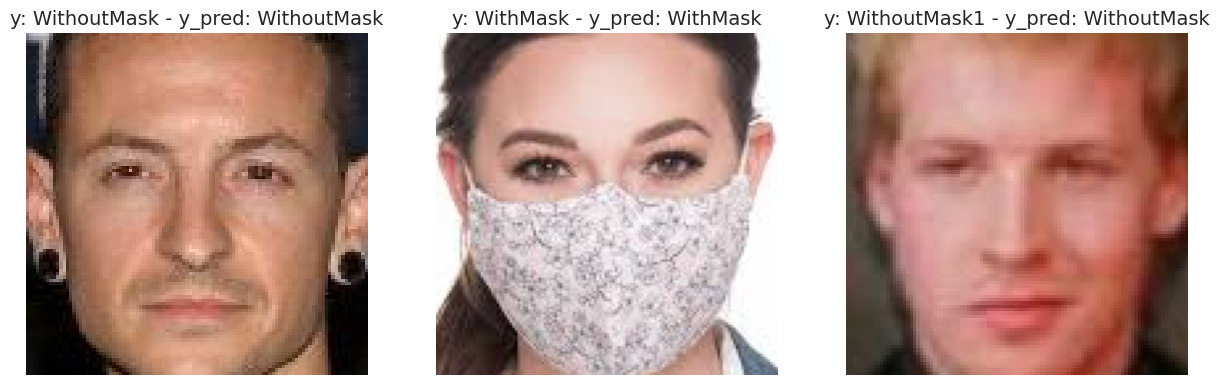

In [15]:
_, axs = plt.subplots(1, 3, figsize=(15, 8))
axs = axs.flatten()
for cnt, image_name in enumerate(['WithoutMask', 'WithMask', 'WithoutMask1']):
    test_img_path = f'test_images/{image_name}.png'
    processed_img = preprocess_image(test_img_path)
    preds = loaded_cnn_model.predict(processed_img)
    pred_label = class_names_list[int(np.round(preds))]

    img = cv2.imread(test_img_path)
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    axs[cnt].imshow(rgb_img)
    axs[cnt].set_title(label=f'y: {image_name} - y_pred: {pred_label}', fontsize=14)
    axs[cnt].grid('off')
    axs[cnt].axis('off')
plt.show()


In [16]:
def predict_single_image(image_path):
    face_detection_haarcascade_file = 'libs/haarcascade/haarcascade_frontalface_default.xml'
    cascade_clf = cv2.CascadeClassifier(face_detection_haarcascade_file)
    img = cv2.imread(image_path)
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # returns a list of (x,y,w,h) tuples
    detected_faces = cascade_clf.detectMultiScale(img_gray, scaleFactor=1.1, minNeighbors=3)
    print(f'detected faces location {detected_faces}')

    # Image plotting
    for (x, y, w, h) in detected_faces:
        cv2.rectangle(img, (x, y), (x + w, y + h), (255, 0, 255), 1)

        cropped_face = img[y:y + h, x:x + w]

        # scaling
        cropped_face = cv2.resize(cropped_face, (IMG_HEIGHT, IMG_WIDTH))
        cropped_face = np.expand_dims(cropped_face / 255, 0)
        prediction = loaded_cnn_model.predict(cropped_face)

        pred_label = class_names_list[int(np.round(prediction))]
        cv2.putText(img,
                    pred_label,
                    (x, y - 10),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX,
                    fontScale=0.3,
                    color=(255, 0, 255),
                    thickness=1
                    )
        print(pred_label)

    output_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    plt.figure(figsize=(12, 12))
    plt.imshow(output_img)
    plt.axis('off')

detected faces location [[ 84  58  38  38]
 [175  53  51  51]]
1/1 [==============================] - 0s 11ms/step
WithoutMask
1/1 [==============================] - 0s 10ms/step
WithMask


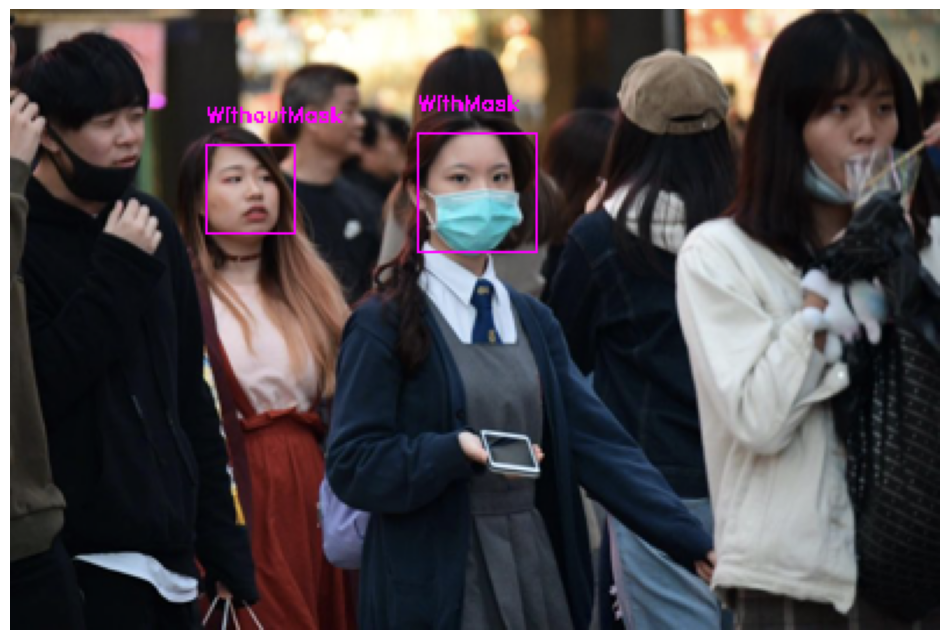

In [17]:
image_path = 'test_images/real-test2.png'
predict_single_image(image_path)

detected faces location [[ 47  97  54  54]
 [170  59  58  58]
 [296  21 102 102]]
1/1 [==============================] - 0s 11ms/step
WithoutMask
1/1 [==============================] - 0s 10ms/step
WithMask
1/1 [==============================] - 0s 12ms/step
WithoutMask


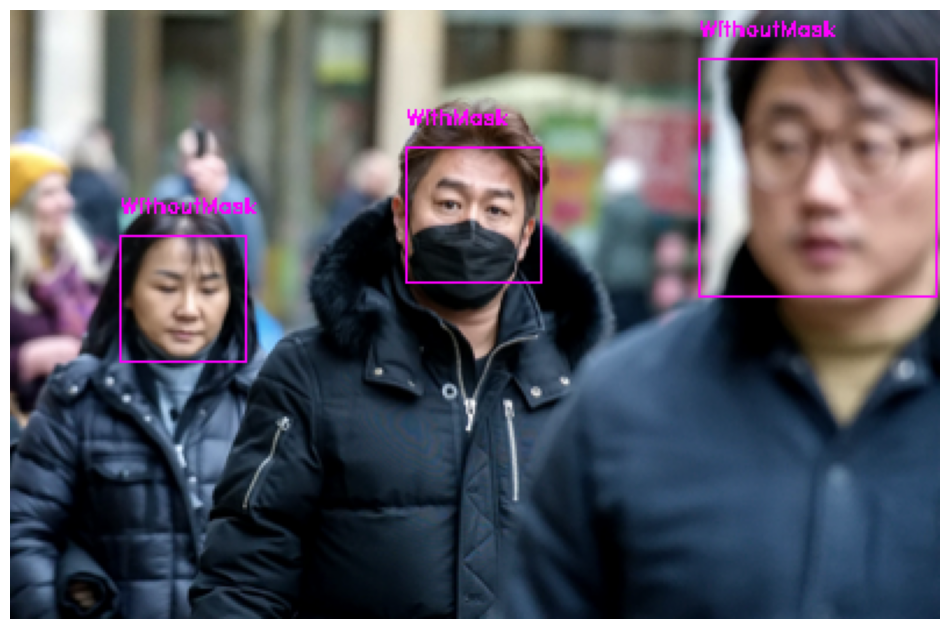

In [18]:
image_path = 'test_images/1.png'
predict_single_image(image_path)